torch.Size([30, 1, 1]) torch.Size([30, 1, 1])
Epoch [1000/1000], Loss: 29.6193


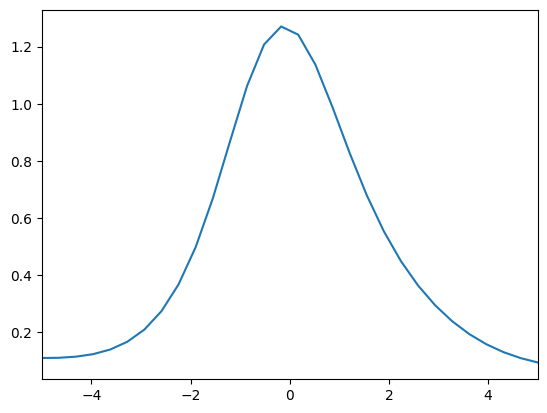

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from softadapt import *
import numpy as np
import scipy.io
import os
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

N = 30

# Define boundary conditions
t0 = 0.0
t_final = torch.pi/2
x_left = -5.
x_right = 5.

# Create input data
X_vals = torch.linspace(x_left, x_right, N, requires_grad=True)
t_vals = torch.linspace(t0, t_final, N, requires_grad=True)
X_train, t_train = torch.meshgrid(X_vals, t_vals, indexing="xy")
X_train = X_train.unsqueeze(-1)
t_train = t_train.unsqueeze(-1)

X_vals_ = X_vals.view(-1,1,1)
t_vals_ = t_vals.view(-1,1,1)

print(X_vals.view(-1,1,1).shape, torch.ones_like(X_vals).view(-1,1,1).shape)


# Define functions h(x), u(x)
phi = lambda x: 2/torch.cosh(x)


#to simulate a complex output we make it spit out two things like this [real, imaginary]
class NeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.fn_approx = nn.Sequential(
            nn.Linear(2,10),
            nn.Tanh(),
            nn.Linear(10,10),
            nn.Tanh(),
            nn.Linear(10,10),
            nn.Tanh(),
            nn.Linear(10,2)
        )

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x, y):
        x_combined = torch.cat((x, y),dim=2)
        logits = self.fn_approx(x_combined)
        return logits

    
model = NeuralNetwork()
model.apply(NeuralNetwork.init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000

#setup for softadapt:

softadapt_object = SoftAdapt(beta=0.1)


epochs_to_make_updates = 5

values_of_component_1 = []
values_of_component_2 = []
values_of_component_3 = []
values_of_component_4 = []


# Initializing adaptive weights to all ones.
adapt_weights = torch.tensor([1,1,1,1])

for epoch in range(num_epochs):
    # Forward pass
    u_prediction = model(X_train, t_train)

    u_real = u_prediction[:,:,0].unsqueeze(-1)
    u_imag = u_prediction[:,:,1].unsqueeze(-1)

    u_left = model(x_left*torch.ones_like(X_vals_),t_vals_)
    u_right = model(x_right*torch.ones_like(X_vals_),t_vals_)
    
    u_ic_real = model(X_vals_, torch.zeros_like(t_vals_))[:,:,0].unsqueeze(-1)
    u_ic_imag = model(X_vals_, torch.zeros_like(t_vals_))[:,:,1].unsqueeze(-1) 

    # Compute the first derivatives
    du_dx_real = torch.autograd.grad(u_real, X_train, create_graph=True, grad_outputs=torch.ones_like(u_real))[0]
    du_dx_imag = torch.autograd.grad(u_imag, X_train, create_graph=True, grad_outputs=torch.ones_like(u_imag))[0]

    du_dt_real = torch.autograd.grad(u_real, t_train, create_graph=True, grad_outputs=torch.ones_like(u_real))[0]
    du_dt_imag = torch.autograd.grad(u_imag, t_train, create_graph=True, grad_outputs=torch.ones_like(u_imag))[0]

    d2u_dx2_real = torch.autograd.grad(du_dx_real, X_train, create_graph=True, grad_outputs=torch.ones_like(u_real))[0]
    d2u_dx2_imag = torch.autograd.grad(du_dx_imag, X_train, create_graph=True, grad_outputs=torch.ones_like(u_imag))[0]
    
    
    bound_left_real = du_dx_real[:,0,0].unsqueeze(-1)
    bound_left_imag = du_dx_imag[:,0,0].unsqueeze(-1)

    bound_right_real = du_dx_real[:,-1,0].unsqueeze(-1)
    bound_right_imag = du_dx_imag[:,-1,0].unsqueeze(-1)

    # Compute the loss for the nonlinear schrodinger eq:
    loss_PDE_real = criterion(-du_dt_imag + 0.5 * d2u_dx2_real + (u_real**2 + u_imag**2) * u_real, torch.zeros_like(u_real))
    loss_PDE_imag = criterion(du_dt_real + 0.5 * d2u_dx2_imag + (u_real**2 + u_imag**2) * u_imag, torch.zeros_like(u_imag))
    loss_PDE = loss_PDE_real + loss_PDE_imag

    loss_IC = criterion(u_ic_real, phi(X_vals_))+criterion(u_ic_imag, torch.zeros_like(X_vals_))

    loss_boundary_2 = criterion(bound_left_real, bound_right_real)+criterion(bound_left_imag, bound_right_imag)

    loss_boundary_1 = criterion(u_left, u_right)

    # Backward pass and optimization
    optimizer.zero_grad()

    #softadapt weights update stuff:
    values_of_component_1.append(loss_PDE)
    values_of_component_2.append(loss_boundary_1)
    values_of_component_3.append(loss_boundary_2)
    values_of_component_4.append(loss_IC)


    if epoch % epochs_to_make_updates == 0 and epoch != 0:
        adapt_weights = softadapt_object.get_component_weights(
        torch.tensor(values_of_component_1), 
        torch.tensor(values_of_component_2), 
        torch.tensor(values_of_component_3),
        torch.tensor(values_of_component_4),
        verbose=False,
        )
                                                            
      
          # Resetting the lists to start fresh (this part is optional)
        values_of_component_1 = []
        values_of_component_2 = []
        values_of_component_3 = []
        values_of_component_4 = []

      # Change 5: Update the loss function with the linear combination of all components.
    loss = 1000*(adapt_weights[0] * loss_PDE + adapt_weights[1] * loss_boundary_1 + adapt_weights[2] * loss_boundary_2 + adapt_weights[3]*loss_IC)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}', end='\r')

print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    #for the 3d plot we import the matplotlib extension:
    from mpl_toolkits.mplot3d import Axes3D
    u_pred = model(X_vals.view(-1,1,1), 0.79*torch.ones_like(X_vals).view(-1,1,1))
    u_pred = u_pred.squeeze(-1).numpy()
    X_vals = X_vals.squeeze(-1).numpy()
    t_vals = t_vals.squeeze(-1).numpy()

#Get data
with torch.no_grad():
    u_pred_timed = model(X_train, t_train).squeeze(-1).numpy()
u_pred_timed_abs = np.sqrt(u_pred_timed[:,:,0]**2+u_pred_timed[:,:,1]**2)
fig, ax = plt.subplots()
line, = ax.plot(X_train.detach().numpy()[0],u_pred_timed_abs[0,:])
ax.set_xlim(-5,5)

def run(frame):
    line.set_ydata(u_pred_timed_abs[frame,:])
    return line,

ani = FuncAnimation(fig, run,frames = range(30),blit=True,interval = 50)

    

In [4]:
HTML(ani.to_jshtml())